In this note, we numerically study the expansion of a surface code.
We first study the expansion without post-selection.

In [3]:
import numpy as np
import stim
import matplotlib.pyplot as plt
import pymatching
import sinter
from typing import List

In [6]:
class SurfaceCode:
    def __init__(self, m: int, n: int, error_rate: float = 0.001):
        self.m = m # Number of columns
        self.n = n # Number of rows
        self.error_rate = error_rate
        self.qubit_dict, self.qubit_list = self.generate_qubit_dict_and_list()
        self.check_list = self.generate_check_list()
        # print(self.check_list)

    def generate_qubit_dict_and_list(self):
        qubit_dict = {}
        qubit_list = []
        idx = 0
        for i in range(self.m):
            for j in range(self.n):
                qubit_dict[(2 * i, 2 * j)] = idx
                qubit_list.append(idx)
                idx += 1
        return qubit_dict, qubit_list

    def generate_check_list(self):
        check_list = []
        idx = self.m * self.n
        # X checks
        for i in range(0, self.m, 2):
            for j in range(self.n - 1):
                pos = [2 * i - 1 + 2 * (j % 2), 2 * j + 1]
                check_list.append({
                    'type': 'X',
                    'pos': pos,
                    "idx": idx,
                    0: self.qubit_dict.get((pos[0] - 1, pos[1] - 1)),
                    1: self.qubit_dict.get((pos[0] - 1, pos[1] + 1)),
                    2: self.qubit_dict.get((pos[0] + 1, pos[1] - 1)),
                    3: self.qubit_dict.get((pos[0] + 1, pos[1] + 1)),
                })
                idx += 1
        # Z checks
        for i in range(self.m - 1):
            for j in range(0, self.n, 2):
                pos = [2 * i + 1, 2 * j + 1 - 2 * (i % 2)]
                check_list.append({
                    'type': 'Z',
                    'pos': pos,
                    "idx": idx,
                    0: self.qubit_dict.get((pos[0] - 1, pos[1] - 1)),
                    1: self.qubit_dict.get((pos[0] + 1, pos[1] - 1)),
                    2: self.qubit_dict.get((pos[0] - 1, pos[1] + 1)),
                    3: self.qubit_dict.get((pos[0] + 1, pos[1] + 1)),
                })
                idx += 1
        return check_list

    def generate_circuit(self, rounds: int = 10):
        circuit = self.initialize_circuit_position()
        self.initialize_circuit(circuit)
        for t in range(rounds):
            self.syndrome_measurement(circuit, t)
        self.Z_measurement(circuit, rounds)
        return circuit

    def initialize_circuit_position(self):
        circuit = stim.Circuit()
        for pos in self.qubit_dict:
            circuit.append("QUBIT_COORDS", self.qubit_dict[pos], pos)
        for check in self.check_list:
            circuit.append("QUBIT_COORDS", check['idx'], check['pos'])
        return circuit

    def initialize_circuit(self, circuit: stim.Circuit):
        circuit = self.initialize_circuit_position()
        # Initialize data qubits
        for i in self.qubit_list:
            circuit.append("R", i)
        # Initialize ancilla qubits
        for i in range(len(self.check_list)):
            if self.check_list[i]['type'] == 'X':
                circuit.append("R", self.check_list[i]['idx'])
            else:
                circuit.append("R", self.check_list[i]['idx'])

    def syndrome_measurement(self, circuit: stim.Circuit, round: int):
        # initialize X-check ancillae
        for check in self.check_list:
            if check['type'] == 'X':
                circuit.append('H', check['idx'])
        for check in self.check_list:
            if check['type'] == 'X':
                circuit.append("DEPOLARIZE1", check['idx'], self.error_rate)
        circuit.append('TICK')

        # CNOT layers
        for i in range(4):
            for check in self.check_list:
                if check['type'] == 'X' and check[i] != None:
                    circuit.append('CNOT', [check['idx'], check[i]])
                if check['type'] == 'Z' and check[i] != None:
                    circuit.append('CNOT', [check[i], check['idx']])
            for check in self.check_list:
                if check['type'] == 'X' and check[i] != None:
                    circuit.append("DEPOLARIZE1", [check['idx'], check[i]], self.error_rate)
                    # circuit.append("CORRELATED_ERROR", [check['idx'], check[i]], self.error_rate)
                if check['type'] == 'Z' and check[i] != None:
                    circuit.append("DEPOLARIZE1", [check[i], check['idx']], self.error_rate)
                    # circuit.append("CORRELATED_ERROR", [check[i], check['idx']], self.error_rate)
            circuit.append('TICK')

        # Hadamard layer for X-check ancillae
        for check in self.check_list:
            if check['type'] == 'X':
                circuit.append('H', check['idx'])
        for check in self.check_list:
            if check['type'] == 'X':
                circuit.append("DEPOLARIZE1", [check['idx']], self.error_rate)
        circuit.append('TICK')

        # syndrome measurement
        for check in self.check_list:
            circuit.append('X_ERROR', [check['idx']], self.error_rate)
        for check in self.check_list:
            circuit.append('MR', [check['idx']])
        circuit.append("DEPOLARIZE1", list(range(2 * self.m * self.n - 1)), self.error_rate)
        circuit.append('TICK')

        # if detector is required, add detector operations
        if round > 0:
            for check in self.check_list:
                rec_idx = check['idx'] - 2 * self.m * self.n + 1 # shift (mn, 2mn-1) to (-mn+1, 0)
                circuit.append('DETECTOR', [stim.target_rec(rec_idx), stim.target_rec(rec_idx - self.m * self.n + 1)], [check['pos'][0], check['pos'][1], round])
        else:
            for check in self.check_list:
                if check['type'] == 'Z':
                    rec_idx = check['idx'] - 2 * self.m * self.n + 1
                    circuit.append('DETECTOR', [stim.target_rec(rec_idx)], [check['pos'][0], check['pos'][1], round])

    def Z_measurement(self, circuit: stim.Circuit, round: int):
        # Measure all data qubits
        circuit.append('X_ERROR', self.qubit_list, self.error_rate)
        circuit.append('MR', self.qubit_list)

        # Extract Z-syndrome and make a detector
        for check in self.check_list:
            if check['type'] == 'Z':
                qubit_rec_shift = - self.m * self.n # shift (0, mn) to (-mn, 0)
                check_rec_shift = - 3 * self.m * self.n + 1 # shift (mn, 2mn-1) to (-2mn + 1, -mn)
                detector_list = [stim.target_rec(check['idx'] + check_rec_shift)] + [stim.target_rec(check[i] + qubit_rec_shift) for i in range(4) if check[i] != None]
                circuit.append('DETECTOR', detector_list, [check['pos'][0], check['pos'][1], round])

        # Extract logical Z
        qubit_rec_shift = - self.m * self.n # shift (0, mn) to (-mn, 0)
        logical_Z = [stim.target_rec(i + qubit_rec_shift) for i in range(self.n)]
        circuit.append('OBSERVABLE_INCLUDE', logical_Z, 0)

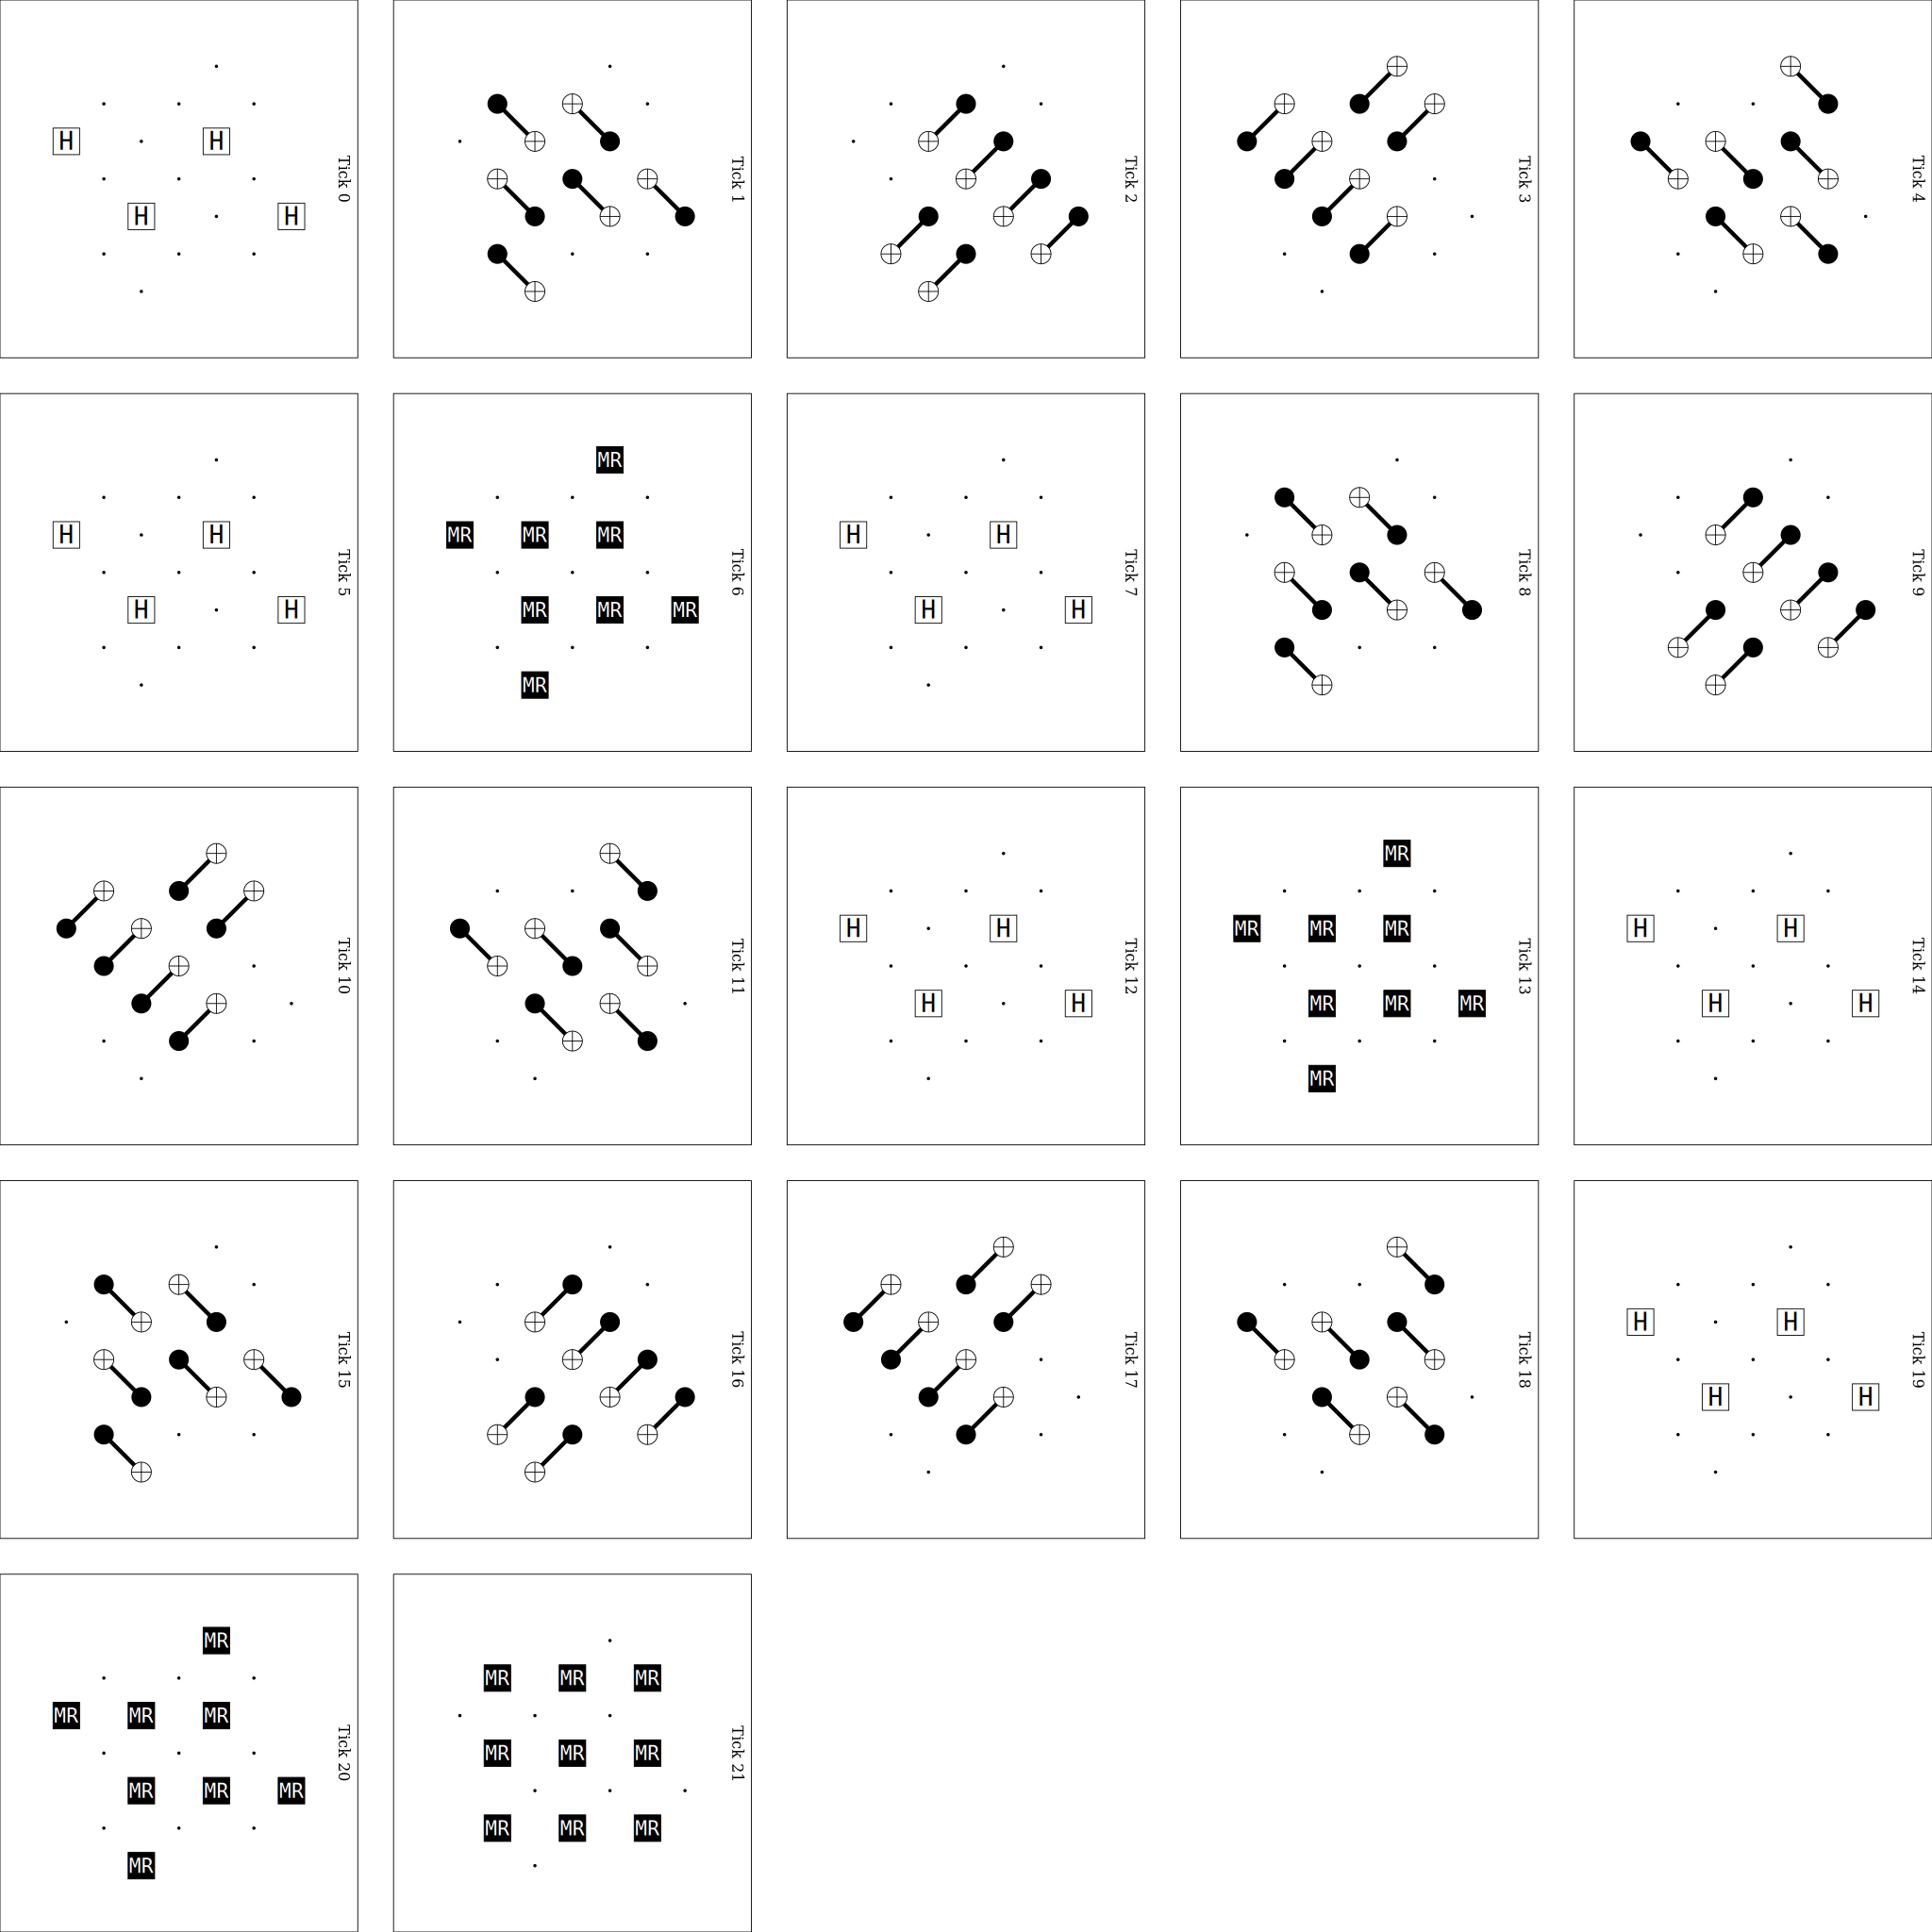

In [7]:
surface_code = SurfaceCode(m=3, n=3, error_rate=0.001)
circuit = surface_code.generate_circuit(rounds=3)
circuit.without_noise().diagram('timeslice-svg')

In [8]:
def init_surface(m, n, error_rate=0.001):
    """
    Initialize an m x n surface code lattice with data and ancilla qubits.
    Returns a Stim Circuit object representing the initialization.
    For simplicity, we assume m and n are both odd.
    """
    # Check if m and n are odd
    if m % 2 == 0 or n % 2 == 0:
        raise ValueError("Both m and n must be odd integers.")

    # Create a Stim Circuit
    circuit = stim.Circuit()

    # Create a map to store check information
    check_list = [{}] * (m * n - 1)

    # Reset all qubits
    circuit.append('R', list(range(2 * m * n - 1)))
    circuit.append("DEPOLARIZE1", list(range(2 * m * n - 1)), error_rate)
    circuit.append('TICK')
    
    # Add qubit coordinates for mn data qubits
    for i in range(m):
        for j in range(n):
            circuit.append("QUBIT_COORDS", i * n + j, [i, j])

    # Add bulk ancilla qubits
    for i in range(m - 1):
        for j in range(n - 1):
            ancilla_index = m * n + i * (n - 1) + j
            check_list[ancilla_index - (m * n)] = {
                'type': 'Z' if (i + j) % 2 == 0 else 'X',
                'pos': [i + 1/2, j + 1/2],
                "idx": ancilla_index,
                0: i * n + j,
                1: (i + 1) * n + j if (i + j) % 2 == 0 else i * n + (j + 1),
                2: i * n + (j + 1) if (i + j) % 2 == 0 else (i + 1) * n + j,
                3: (i + 1) * n + (j + 1) 
            }

    # Add boundary ancilla qubits
    for i in range(4):
        # X checks on left and right boundaries, totally n - 1 ancilla qubits
        if i % 2 == 0:
            for j in range(n // 2):
                ancilla_index = m * n + (m - 1) * (n - 1) + (i // 2) * (n // 2) + j
                check_list[ancilla_index - (m * n)] = {
                    'type': 'X',
                    'pos': [-1/2 + i // 2 * m, 2*j + 1/2 + i // 2],
                    "idx": ancilla_index,
                    0: (m - 1) * n + 2 * j + 1 if (i // 2) == 1 else None,
                    1: (m - 1) * n + 2 * j + 2 if (i // 2) == 1 else None,
                    2: 2 * j if (i // 2) == 0 else None,
                    3: 2 * j + 1 if (i // 2) == 0 else None
                }

        # Z checks on top and bottom boundaries, totally m - 1 ancilla qubits
        else:
            for j in range(m // 2):
                ancilla_index = m * n + (m - 1) * (n - 1) + (n - 1) + (i // 2) * (m // 2) + j
                check_list[ancilla_index - (m * n)] = {
                    'type': 'Z',
                    'pos': [2*j + 1/2 + 1 - i // 2, -1/2 + i // 2 * n],
                    "idx": ancilla_index,
                    0: (2 * j + 1) * n - 1 if (i // 2) == 1 else None,
                    1: (2 * j + 2) * n - 1 if (i // 2) == 1 else None,
                    2: (2 * j + 1) * n if (i // 2) == 0 else None,
                    3: (2 * j + 2) * n if (i // 2) == 0 else None
                }

    for check in check_list:
        circuit.append("QUBIT_COORDS", check['idx'], check['pos'])

    return circuit, check_list

def syndrome_measurement_surface(circuit: stim.Circuit, check_list: list[map], m, n,error_rate=0.001, t=0):
    """
    Perform syndrome measurement for the surface code.
    This function adds the necessary gates and measurements to the circuit.
    """
    # Check if m and n are odd
    if m % 2 == 0 or n % 2 == 0:
        raise ValueError("Both m and n must be odd integers.")

    # initialize X-check ancillae
    for check in check_list:
        if check['type'] == 'X':
            circuit.append('H', check['idx'])
    for check in check_list:
        if check['type'] == 'X':
            circuit.append("DEPOLARIZE1", check['idx'], error_rate)
    circuit.append('TICK')

    # CNOT layers
    for i in range(4):
        for check in check_list:
            if check['type'] == 'X' and check[i] != None:
                circuit.append('CNOT', [check['idx'], check[i]])
            if check['type'] == 'Z' and check[i] != None:
                circuit.append('CNOT', [check[i], check['idx']])
        for check in check_list:
            if check['type'] == 'X' and check[i] != None:
                circuit.append("DEPOLARIZE1", [check['idx'], check[i]], error_rate)
                # circuit.append("CORRELATED_ERROR", [check['idx'], check[i]], error_rate)
            if check['type'] == 'Z' and check[i] != None:
                circuit.append("DEPOLARIZE1", [check[i], check['idx']], error_rate)
                # circuit.append("CORRELATED_ERROR", [check[i], check['idx']], error_rate)
        circuit.append('TICK')

    # Hadamard layer for X-check ancillae
    for check in check_list:
        if check['type'] == 'X':
            circuit.append('H', check['idx'])
    for check in check_list:
        if check['type'] == 'X':
            circuit.append("DEPOLARIZE1", [check['idx']], error_rate)
    circuit.append('TICK')

    # syndrome measurement
    for check in check_list:
        circuit.append('X_ERROR', [check['idx']], error_rate)
    for check in check_list:
        circuit.append('MR', [check['idx']])
    circuit.append("DEPOLARIZE1", list(range(2 * m * n - 1)), error_rate)
    circuit.append('TICK')

    # if detector is required, add detector operations
    if t > 0:
        for check in check_list:
            rec_idx = check['idx'] - 2 * m * n + 1 # shift (mn, 2mn-1) to (-mn+1, 0)
            circuit.append('DETECTOR', [stim.target_rec(rec_idx), stim.target_rec(rec_idx - m * n + 1)], [check['pos'][0], check['pos'][1], t])
    else:
        for check in check_list:
            if check['type'] == 'Z':
                rec_idx = check['idx'] - 2 * m * n + 1
                circuit.append('DETECTOR', [stim.target_rec(rec_idx)], [check['pos'][0], check['pos'][1], t])

def Z_measurement_surface(circuit: stim.Circuit, check_list: list[map], m, n, error_rate=0.001, t=-1):
    # Measure all data qubits
    circuit.append('X_ERROR', list(range(m * n)), error_rate)
    circuit.append('MR', list(range(m * n)))

    # Extract Z-syndrome and make a detector
    for check in check_list:
        if check['type'] == 'Z':
            qubit_rec_shift = - m * n # shift (0, mn) to (-mn, 0)
            check_rec_shift = - 3 * m * n + 1 # shift (mn, 2mn-1) to (-2mn + 1, -mn)
            detector_list = [stim.target_rec(check['idx'] + check_rec_shift)] + [stim.target_rec(check[i] + qubit_rec_shift) for i in range(4) if check[i] != None]
            circuit.append('DETECTOR', detector_list, [check['pos'][0], check['pos'][1], t])

    # Extract logical Z
    qubit_rec_shift = - m * n # shift (0, mn) to (-mn, 0)
    logical_Z = [stim.target_rec(i + qubit_rec_shift) for i in range(n)]
    circuit.append('OBSERVABLE_INCLUDE', logical_Z, 0)


def full_surface(m, n, error_rate=0.001, num_rounds=1):
    """
    Create a full surface code circuit with syndrome measurement.
    m and n are the dimensions of the surface code lattice.
    """
    circuit, check_list = init_surface(m, n)
    
    # Perform syndrome measurement
    for t in range(num_rounds):
        syndrome_measurement_surface(circuit, check_list, m, n, error_rate, t)
    Z_measurement_surface(circuit, check_list, m, n, error_rate, num_rounds)

    return circuit

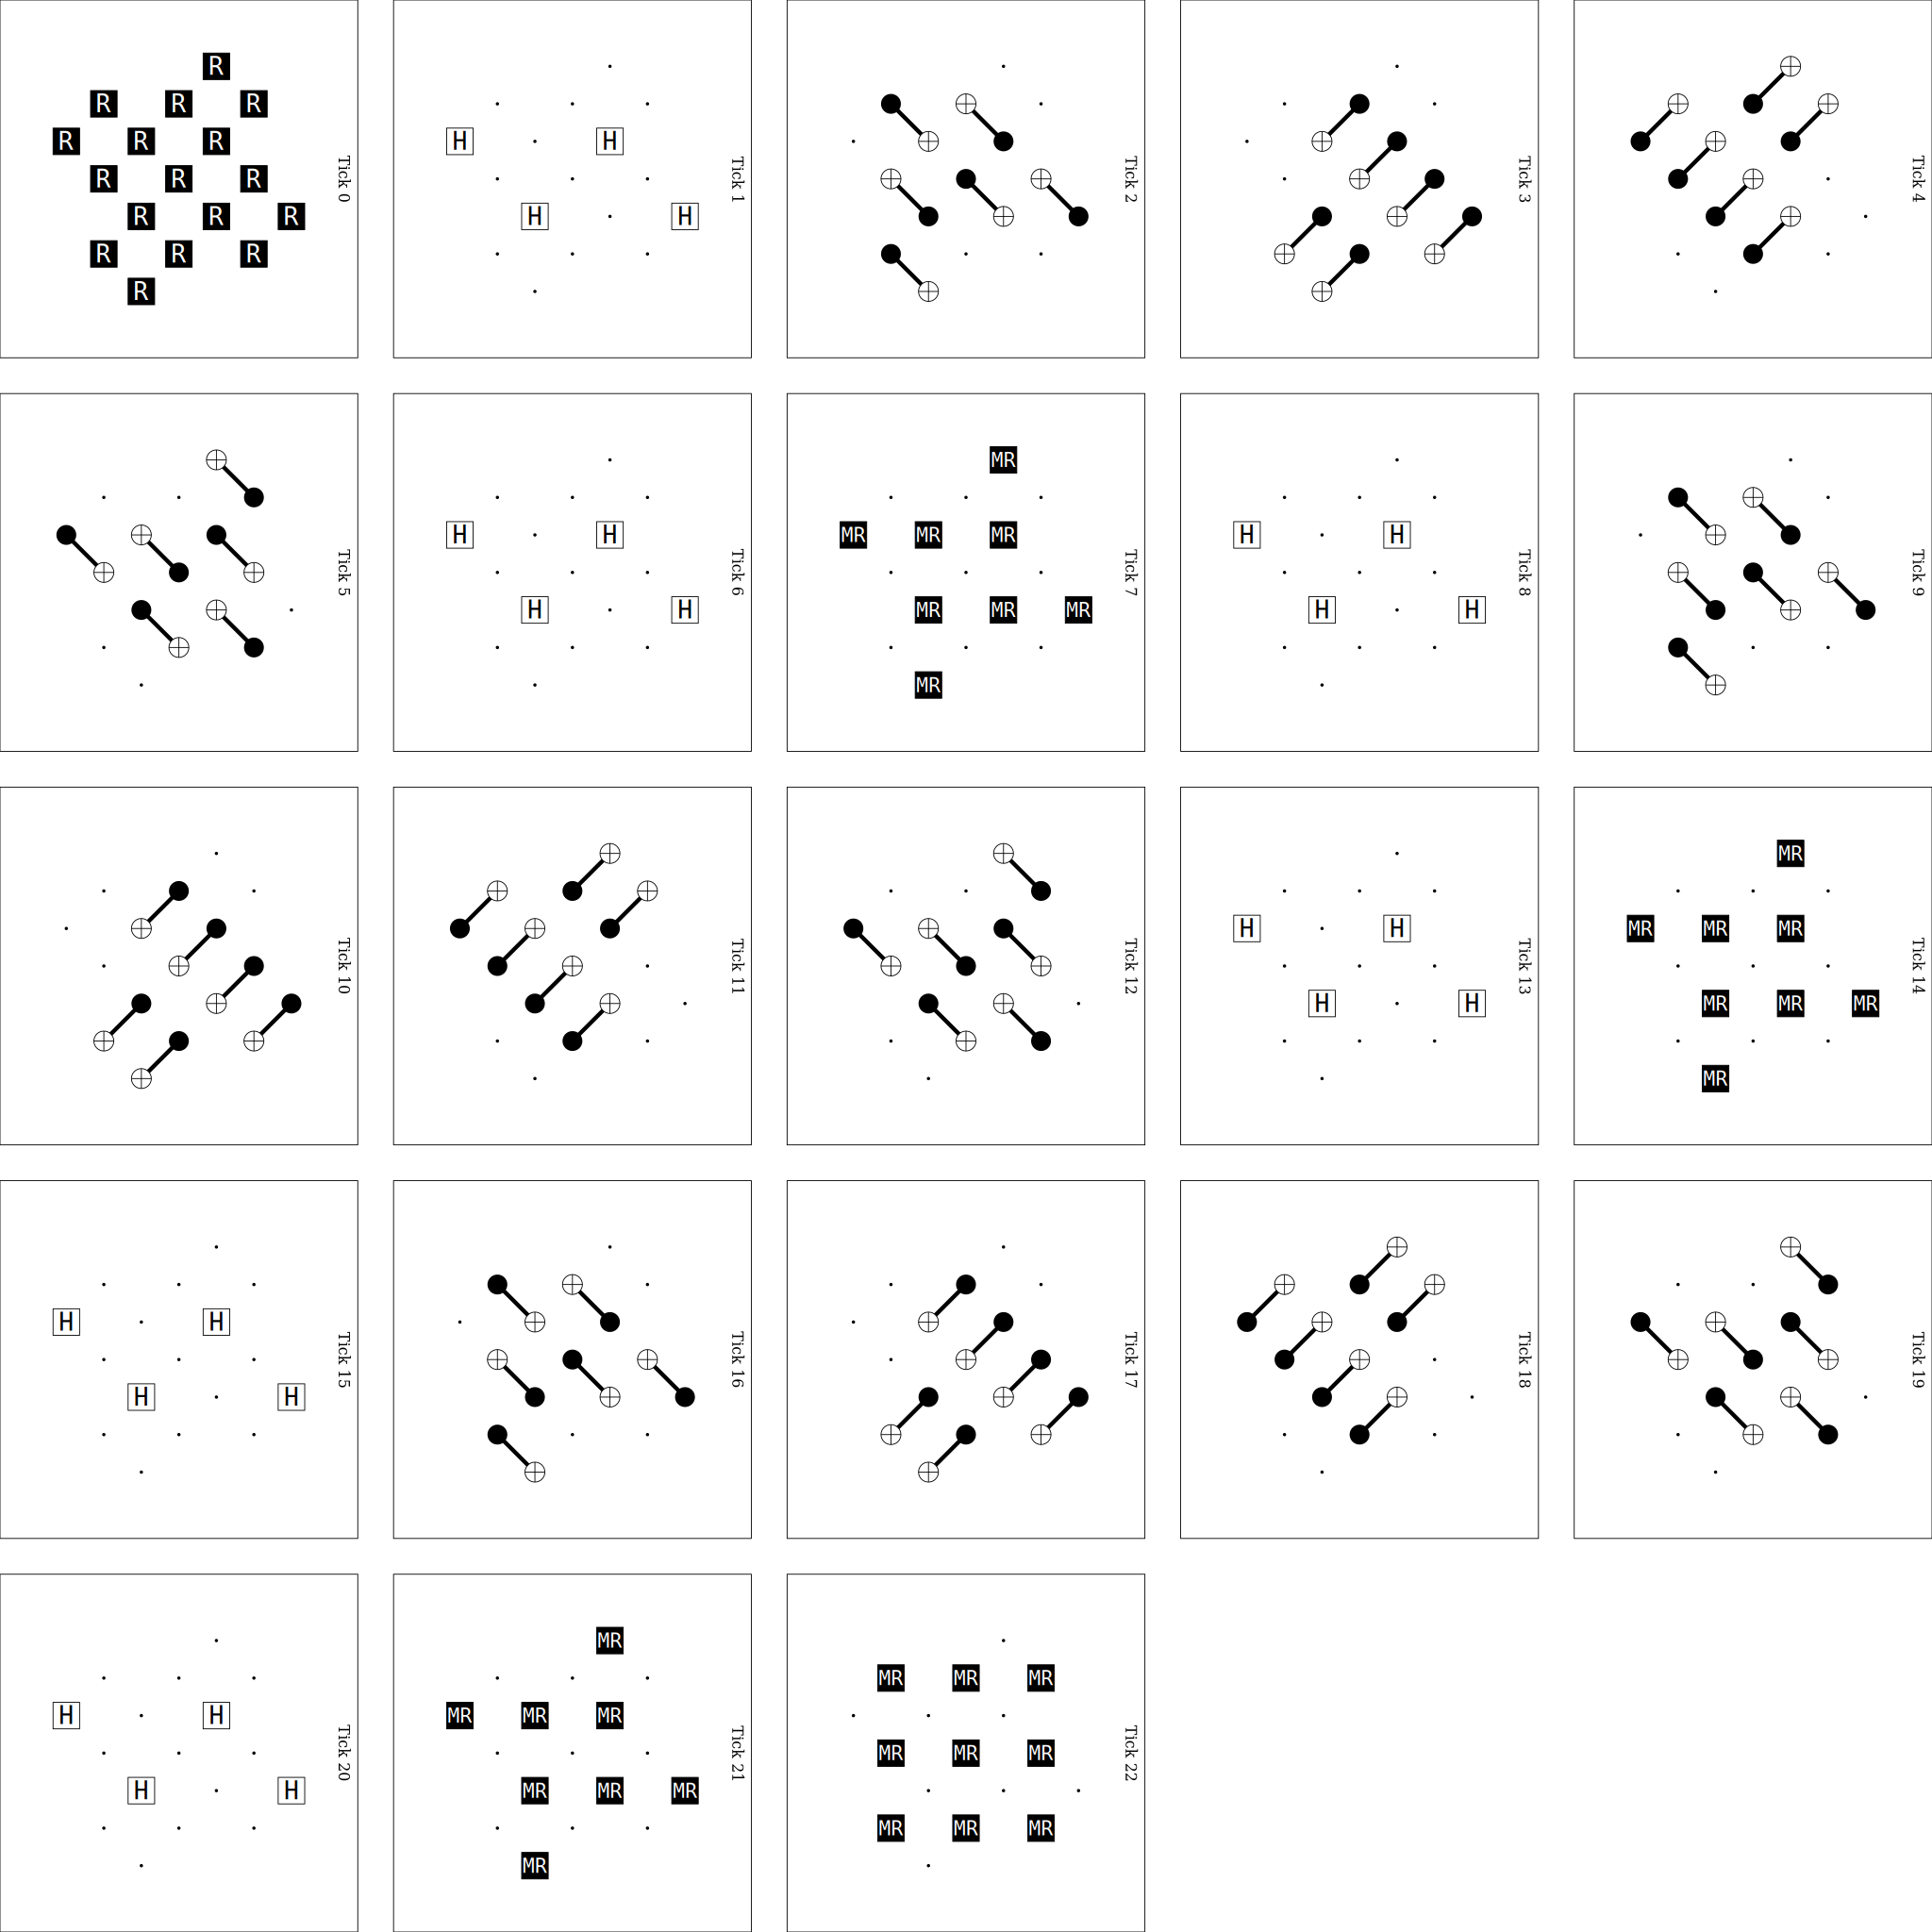

In [10]:
m, n = 3, 3
circuit = full_surface(m, n, 0.001, 3)
circuit.without_noise().diagram('timeslice-svg')